In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [3]:
device = torch.device("cuda")

$MNIST$数据集

In [4]:
mnist_train = torchvision.datasets.MNIST(root='~/test/Datasets/MNIST',train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root='~/test/Datasets/MNIST',train=False, download=True, transform=transforms.ToTensor())

In [5]:
batch_size = 256
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,shuffle=True, num_workers=2)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size,shuffle=False, num_workers=2)

In [6]:
class My_SoftmaxNet(nn.Module):
    def __init__(self,num_inputs,num_outputs):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.w = nn.Parameter(torch.normal(0, 0.01, size=(self.num_inputs, self.num_outputs), requires_grad=True))
        self.b = nn.Parameter(torch.zeros(self.num_outputs, requires_grad=True))
        self.sigmoid = nn.Sigmoid()
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def softmax(self,x):
        X_exp = torch.exp(x)
        partition = X_exp.sum(1, keepdim=True)
        return X_exp / partition  # 这里应用了广播机制
    
    def forward(self,x):
        initial_output = self.sigmoid(torch.mm(x.view(-1,self.num_inputs),self.w)+self.b)
        softmax_output = self.softmax(initial_output)
        return softmax_output

In [7]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))

In [8]:
def evaluate_accuracy(data_iter, net, loss):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        y_hat = y_hat.squeeze()
        acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        l = loss(y_hat, y).sum()
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum/n, test_l_sum/n

In [9]:
def train(net,train_iter,test_iter,loss,num_epochs,optimizer_w,optimizer_b):
    train_loss=[]
    test_loss=[]
    train_accuracy=[]
    test_accuracy=[]
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            y = y.to(device) 
            y_hat = net(X)
            w,b = net.parameters()
            y_hat = y_hat.squeeze()
            l=loss(y_hat,y).sum()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            l.backward()
            optimizer_w.step()
            optimizer_b.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        test_acc,test_l = evaluate_accuracy(test_iter,net,loss)
        train_loss.append(train_l_sum/n)
        test_loss.append(test_l)
        train_accuracy.append(train_acc_sum/n)
        test_accuracy.append(test_acc)
        print('epoch%d,loss%.4f,train acc %3f,test acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,test_acc))
    for params in net.parameters():
        print(params)
    return train_loss,test_loss,train_accuracy,test_accuracy

In [52]:
num_inputs = 784
num_outputs = 10
num_epochs = 50
lr = 0.3
net = My_SoftmaxNet(num_inputs,num_outputs)
net.to(device)
#optimizer=optim.SGD(net.parameters(),lr)
optimizer_w = optim.SGD(params=[net.w],lr=lr,weight_decay=1e-4)
optimizer_b = optim.SGD(params=[net.b],lr=lr)
loss = cross_entropy

In [11]:
import matplotlib.pyplot as plt
import numpy as np
def visualization(train_loss,test_loss,train_accuracy,test_accuracy):
    plt.figure(1)
    x1=np.linspace(0,len(train_loss),len(train_loss))
    plt.plot(x1,train_loss,label='train_loss',linewidth=1.5)
    plt.plot(x1,test_loss,label='test_loss',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

    plt.figure(2)
    x2 = np.linspace(0,len(train_accuracy),len(train_accuracy))
    plt.plot(x2,train_accuracy,label='train_accuracy',linewidth=1.5)
    plt.plot(x2,test_accuracy,label='test_accuracy',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()    
    plt.show()

In [33]:
#wd = 1e-4
train_loss,test_loss,train_accuracy,test_accuracy=train(net,train_iter,test_iter,loss,num_epochs,optimizer_w,optimizer_b)

epoch1,loss1.6637,train acc 0.788050,test acc 0.825
epoch2,loss1.6297,train acc 0.826600,test acc 0.836
epoch3,loss1.6235,train acc 0.832267,test acc 0.835
epoch4,loss1.6204,train acc 0.835750,test acc 0.838
epoch5,loss1.5742,train acc 0.886783,test acc 0.907
epoch6,loss1.5557,train acc 0.903150,test acc 0.905
epoch7,loss1.5522,train acc 0.905133,test acc 0.908
epoch8,loss1.5507,train acc 0.908167,test acc 0.912
epoch9,loss1.5488,train acc 0.908167,test acc 0.913
epoch10,loss1.5474,train acc 0.909483,test acc 0.911
epoch11,loss1.5469,train acc 0.909917,test acc 0.908
epoch12,loss1.5458,train acc 0.910633,test acc 0.914
epoch13,loss1.5457,train acc 0.910900,test acc 0.913
epoch14,loss1.5450,train acc 0.910417,test acc 0.915
epoch15,loss1.5440,train acc 0.911733,test acc 0.912
epoch16,loss1.5433,train acc 0.912500,test acc 0.913
epoch17,loss1.5429,train acc 0.912167,test acc 0.914
epoch18,loss1.5425,train acc 0.913117,test acc 0.912
epoch19,loss1.5423,train acc 0.913333,test acc 0.911
ep

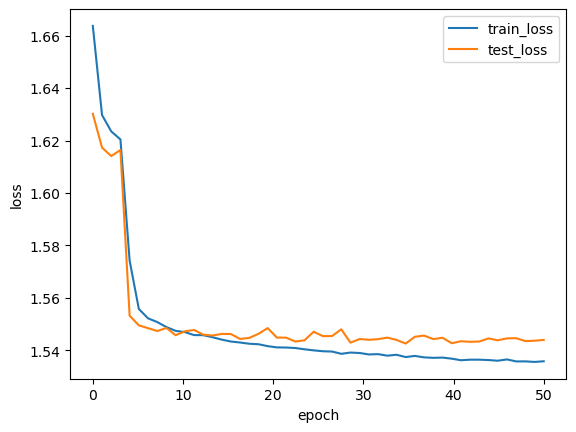

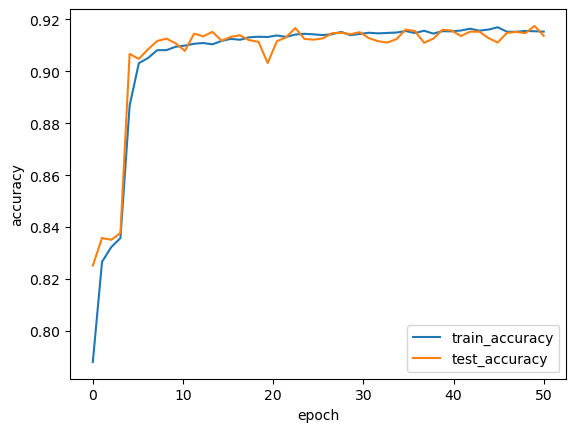

In [34]:
visualization(train_loss,test_loss,train_accuracy,test_accuracy)

In [44]:
#wd = 1e-5
optimizer_w = optim.SGD(params=[net.w],lr=lr,weight_decay=1e-5)
train_loss,test_loss,train_accuracy,test_accuracy=train(net,train_iter,test_iter,loss,num_epochs,optimizer_w,optimizer_b)

epoch1,loss1.6148,train acc 0.825567,test acc 0.892
epoch2,loss1.5677,train acc 0.890433,test acc 0.898
epoch3,loss1.5611,train acc 0.897700,test acc 0.906
epoch4,loss1.5568,train acc 0.901767,test acc 0.910
epoch5,loss1.5539,train acc 0.904217,test acc 0.910
epoch6,loss1.5526,train acc 0.906483,test acc 0.908
epoch7,loss1.5502,train acc 0.908583,test acc 0.908
epoch8,loss1.5489,train acc 0.909167,test acc 0.909
epoch9,loss1.5480,train acc 0.910050,test acc 0.910
epoch10,loss1.5471,train acc 0.910167,test acc 0.904
epoch11,loss1.5455,train acc 0.910767,test acc 0.909
epoch12,loss1.5448,train acc 0.911183,test acc 0.913
epoch13,loss1.5447,train acc 0.911633,test acc 0.910
epoch14,loss1.5433,train acc 0.911883,test acc 0.912
epoch15,loss1.5430,train acc 0.912200,test acc 0.914
epoch16,loss1.5423,train acc 0.913217,test acc 0.904
epoch17,loss1.5418,train acc 0.913850,test acc 0.912
epoch18,loss1.5413,train acc 0.913517,test acc 0.913
epoch19,loss1.5413,train acc 0.912800,test acc 0.914
ep

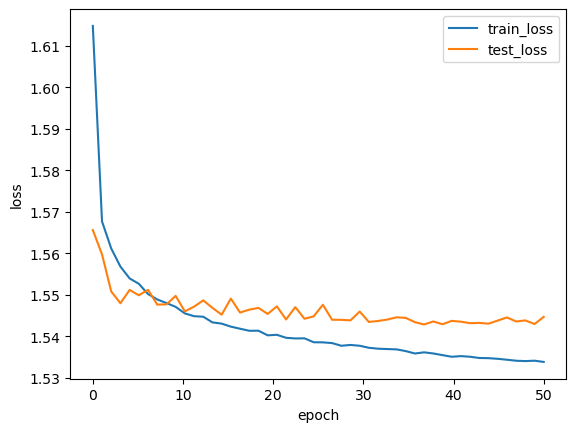

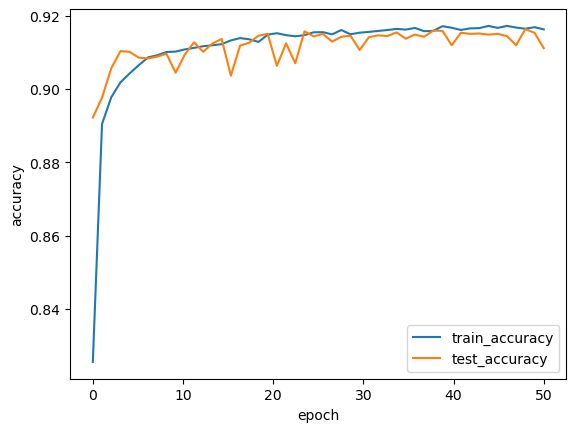

In [45]:
visualization(train_loss,test_loss,train_accuracy,test_accuracy)

In [47]:
optimizer_w = optim.SGD(params=[net.w],lr=lr,weight_decay=1e-3)
#wd = 1e-3
train_loss,test_loss,train_accuracy,test_accuracy=train(net,train_iter,test_iter,loss,num_epochs,optimizer_w,optimizer_b)

epoch1,loss1.6953,train acc 0.475683,test acc 0.896
epoch2,loss1.5705,train acc 0.885617,test acc 0.901
epoch3,loss1.5630,train acc 0.896533,test acc 0.904
epoch4,loss1.5588,train acc 0.898633,test acc 0.901
epoch5,loss1.5566,train acc 0.901717,test acc 0.906
epoch6,loss1.5545,train acc 0.903717,test acc 0.904
epoch7,loss1.5535,train acc 0.905767,test acc 0.907
epoch8,loss1.5526,train acc 0.905383,test acc 0.910
epoch9,loss1.5513,train acc 0.907450,test acc 0.908
epoch10,loss1.5511,train acc 0.906683,test acc 0.904
epoch11,loss1.5507,train acc 0.906717,test acc 0.914
epoch12,loss1.5498,train acc 0.907783,test acc 0.910
epoch13,loss1.5497,train acc 0.906700,test acc 0.910
epoch14,loss1.5497,train acc 0.907000,test acc 0.907
epoch15,loss1.5497,train acc 0.906883,test acc 0.908
epoch16,loss1.5493,train acc 0.907483,test acc 0.900
epoch17,loss1.5485,train acc 0.907600,test acc 0.911
epoch18,loss1.5484,train acc 0.907650,test acc 0.909
epoch19,loss1.5484,train acc 0.907967,test acc 0.904
ep

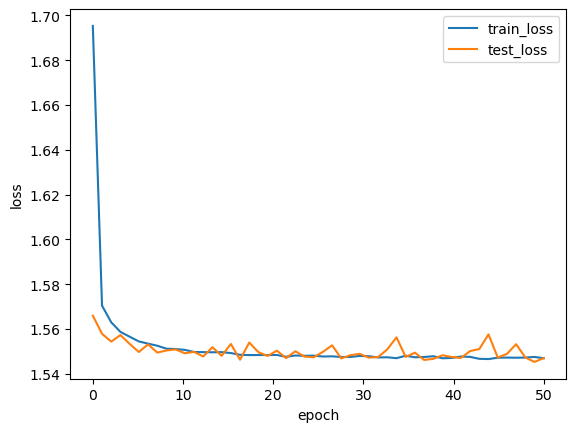

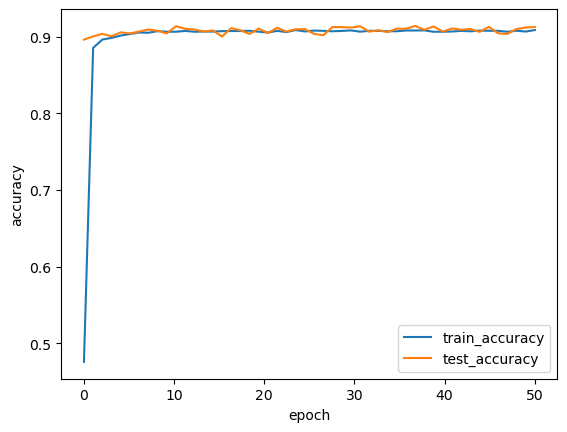

In [48]:
visualization(train_loss,test_loss,train_accuracy,test_accuracy)

In [50]:
optimizer_w = optim.SGD(params=[net.w],lr=lr,weight_decay=1e-2)
#wd = 1e-2
train_loss,test_loss,train_accuracy,test_accuracy=train(net,train_iter,test_iter,loss,num_epochs,optimizer_w,optimizer_b)

epoch1,loss1.6723,train acc 0.765967,test acc 0.811
epoch2,loss1.5952,train acc 0.862450,test acc 0.896
epoch3,loss1.5816,train acc 0.874583,test acc 0.897
epoch4,loss1.5793,train acc 0.879417,test acc 0.896
epoch5,loss1.5789,train acc 0.877150,test acc 0.886
epoch6,loss1.5783,train acc 0.877450,test acc 0.879
epoch7,loss1.5787,train acc 0.877400,test acc 0.889
epoch8,loss1.5781,train acc 0.879250,test acc 0.898
epoch9,loss1.5778,train acc 0.880433,test acc 0.892
epoch10,loss1.5780,train acc 0.878683,test acc 0.888
epoch11,loss1.5778,train acc 0.878817,test acc 0.899
epoch12,loss1.5771,train acc 0.880483,test acc 0.888
epoch13,loss1.5779,train acc 0.879633,test acc 0.901
epoch14,loss1.5774,train acc 0.880217,test acc 0.884
epoch15,loss1.5775,train acc 0.881717,test acc 0.895
epoch16,loss1.5774,train acc 0.880200,test acc 0.904
epoch17,loss1.5779,train acc 0.878283,test acc 0.897
epoch18,loss1.5782,train acc 0.877800,test acc 0.865
epoch19,loss1.5771,train acc 0.879233,test acc 0.854
ep

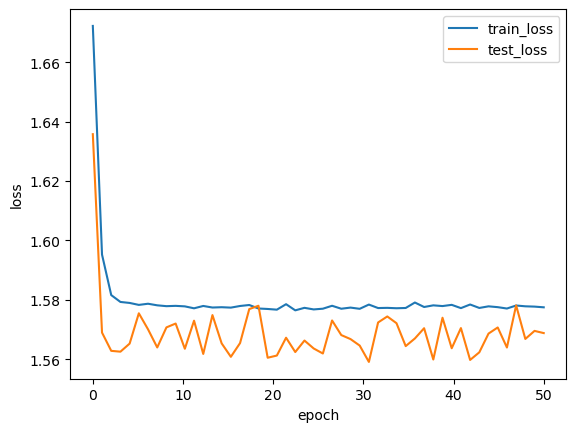

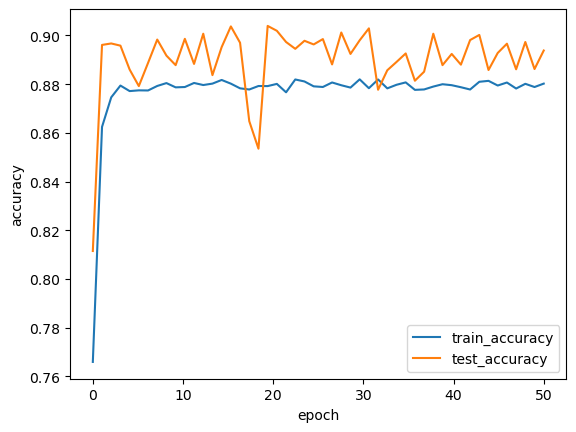

In [51]:
visualization(train_loss,test_loss,train_accuracy,test_accuracy)

In [53]:
optimizer_w = optim.SGD(params=[net.w],lr=lr,weight_decay=1e-1)
#wd = 1e-1
train_loss,test_loss,train_accuracy,test_accuracy=train(net,train_iter,test_iter,loss,num_epochs,optimizer_w,optimizer_b)

epoch1,loss1.7166,train acc 0.677483,test acc 0.811
epoch2,loss1.6922,train acc 0.715550,test acc 0.831
epoch3,loss1.6937,train acc 0.709850,test acc 0.837
epoch4,loss1.6907,train acc 0.715233,test acc 0.860
epoch5,loss1.6918,train acc 0.716617,test acc 0.825
epoch6,loss1.6894,train acc 0.715500,test acc 0.818
epoch7,loss1.6888,train acc 0.718067,test acc 0.858
epoch8,loss1.6894,train acc 0.711867,test acc 0.823
epoch9,loss1.6884,train acc 0.720367,test acc 0.863
epoch10,loss1.6907,train acc 0.718367,test acc 0.851
epoch11,loss1.6906,train acc 0.715100,test acc 0.845
epoch12,loss1.7180,train acc 0.691300,test acc 0.790
epoch13,loss1.7371,train acc 0.679067,test acc 0.763
epoch14,loss1.7354,train acc 0.690250,test acc 0.738
epoch15,loss1.7402,train acc 0.668133,test acc 0.763
epoch16,loss1.7378,train acc 0.687067,test acc 0.776
epoch17,loss1.7393,train acc 0.681733,test acc 0.707
epoch18,loss1.7418,train acc 0.662700,test acc 0.734
epoch19,loss1.7369,train acc 0.684417,test acc 0.493
ep

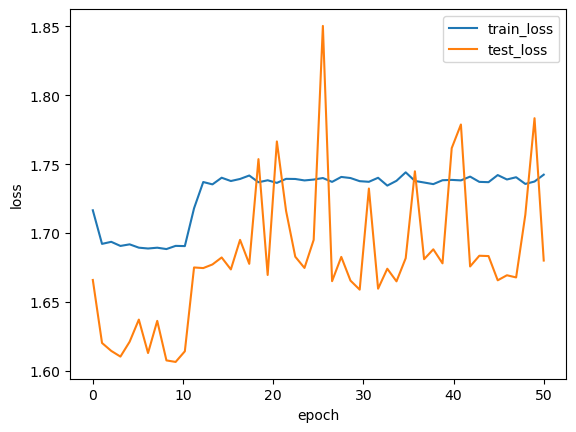

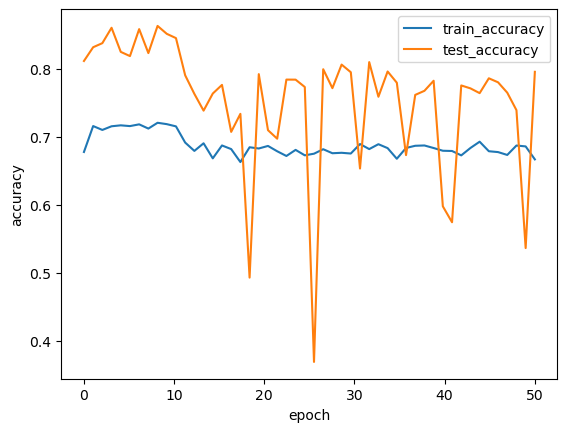

In [54]:
visualization(train_loss,test_loss,train_accuracy,test_accuracy)

In [38]:
optimizer_w = optim.SGD(params=[net.w],lr=lr,weight_decay=0)
#wd = 0
train_loss,test_loss,train_accuracy,test_accuracy=train(net,train_iter,test_iter,loss,num_epochs,optimizer_w,optimizer_b)

epoch1,loss1.6120,train acc 0.809733,test acc 0.893
epoch2,loss1.5676,train acc 0.891983,test acc 0.895
epoch3,loss1.5612,train acc 0.896000,test acc 0.905
epoch4,loss1.5569,train acc 0.901183,test acc 0.903
epoch5,loss1.5534,train acc 0.905850,test acc 0.906
epoch6,loss1.5518,train acc 0.905383,test acc 0.906
epoch7,loss1.5498,train acc 0.907117,test acc 0.909
epoch8,loss1.5488,train acc 0.907567,test acc 0.909
epoch9,loss1.5476,train acc 0.909750,test acc 0.916
epoch10,loss1.5464,train acc 0.911000,test acc 0.911
epoch11,loss1.5455,train acc 0.912433,test acc 0.914
epoch12,loss1.5455,train acc 0.911800,test acc 0.915
epoch13,loss1.5441,train acc 0.911567,test acc 0.912
epoch14,loss1.5437,train acc 0.912867,test acc 0.912
epoch15,loss1.5433,train acc 0.912767,test acc 0.912
epoch16,loss1.5423,train acc 0.913533,test acc 0.911
epoch17,loss1.5418,train acc 0.912600,test acc 0.912
epoch18,loss1.5415,train acc 0.913317,test acc 0.909
epoch19,loss1.5414,train acc 0.913217,test acc 0.912
ep

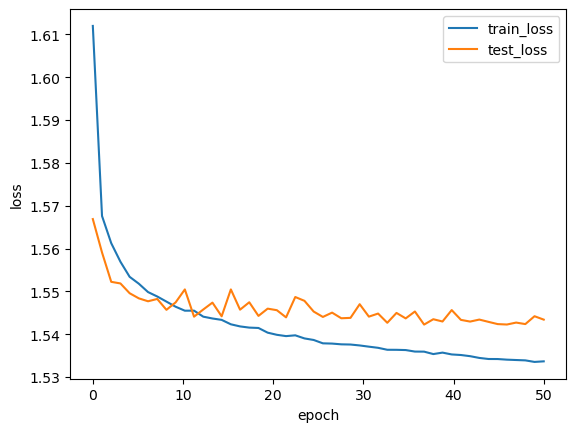

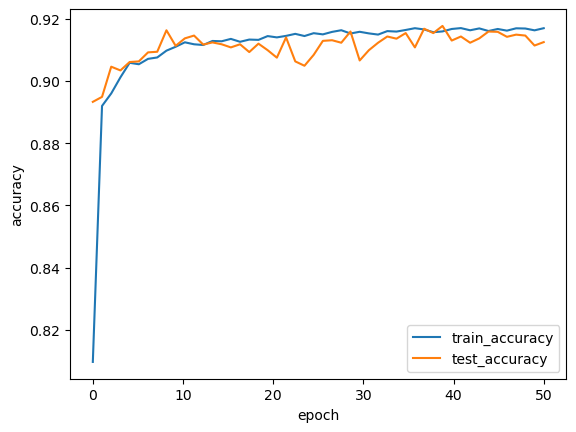

In [39]:
visualization(train_loss,test_loss,train_accuracy,test_accuracy)

In [41]:
optimizer_w = optim.SGD(params=[net.w],lr=lr,weight_decay=1)
#wd = 0
train_loss,test_loss,train_accuracy,test_accuracy=train(net,train_iter,test_iter,loss,num_epochs,optimizer_w,optimizer_b)

epoch1,loss2.2977,train acc 0.208717,test acc 0.268
epoch2,loss2.3046,train acc 0.206117,test acc 0.213
epoch3,loss2.2857,train acc 0.188333,test acc 0.190
epoch4,loss2.2951,train acc 0.169717,test acc 0.114
epoch5,loss2.2821,train acc 0.182067,test acc 0.173
epoch6,loss2.2893,train acc 0.178517,test acc 0.272
epoch7,loss2.2815,train acc 0.198317,test acc 0.241
epoch8,loss2.2906,train acc 0.158133,test acc 0.140
epoch9,loss2.2793,train acc 0.160883,test acc 0.114
epoch10,loss2.2837,train acc 0.167500,test acc 0.235
epoch11,loss2.2909,train acc 0.178617,test acc 0.119
epoch12,loss2.2865,train acc 0.174283,test acc 0.273
epoch13,loss2.2892,train acc 0.181933,test acc 0.169
epoch14,loss2.2750,train acc 0.169600,test acc 0.174
epoch15,loss2.2877,train acc 0.164600,test acc 0.202
epoch16,loss2.2895,train acc 0.175350,test acc 0.208
epoch17,loss2.2891,train acc 0.165900,test acc 0.114
epoch18,loss2.2826,train acc 0.187383,test acc 0.135
epoch19,loss2.2865,train acc 0.199400,test acc 0.114
ep

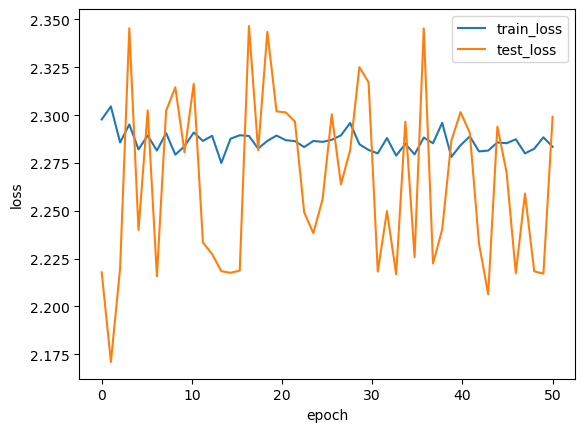

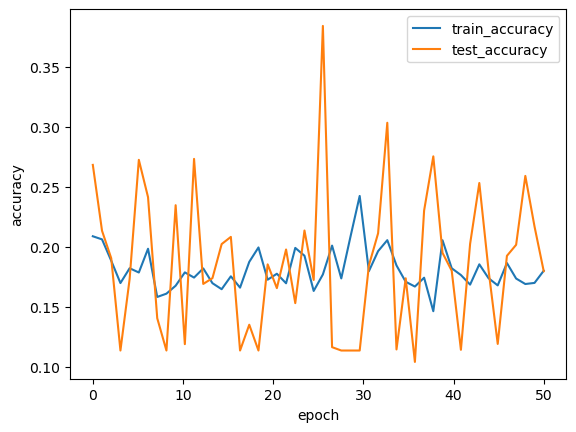

In [42]:
visualization(train_loss,test_loss,train_accuracy,test_accuracy)